# Import data
- Browse MathPlacement.csv
- Insert SparkSession DataFrame

In [55]:
# The code was removed by DSX for sharing.

[Row(_c0=u'1', Student=u'625', Gender=u'0', PSATM=u'56', SATM=u'56', ACTM=u'25', Rank=u'1', Size=u'420', GPAadj=u'40', PlcmtScore=u'23', Recommends=u'R0', Course=u'210', Grade=u'A', RecTaken=u'1', TooHigh=u'0', TooLow=u'0', CourseSuccess=u'1'),
 Row(_c0=u'2', Student=u'628', Gender=u'0', PSATM=u'57', SATM=u'NA', ACTM=u'23', Rank=u'1', Size=u'85', GPAadj=u'40', PlcmtScore=u'21', Recommends=u'R0', Course=u'117', Grade=u'A', RecTaken=u'1', TooHigh=u'0', TooLow=u'0', CourseSuccess=u'1'),
 Row(_c0=u'3', Student=u'629', Gender=u'1', PSATM=u'NA', SATM=u'62', ACTM=u'27', Rank=u'42', Size=u'421', GPAadj=u'38', PlcmtScore=u'20', Recommends=u'R0', Course=u'117', Grade=u'A-', RecTaken=u'1', TooHigh=u'0', TooLow=u'0', CourseSuccess=u'1'),
 Row(_c0=u'4', Student=u'630', Gender=u'0', PSATM=u'53', SATM=u'NA', ACTM=u'27', Rank=u'6', Size=u'75', GPAadj=u'38', PlcmtScore=u'20', Recommends=u'R0', Course=u'117', Grade=u'B', RecTaken=u'1', TooHigh=u'0', TooLow=u'0', CourseSuccess=u'1'),
 Row(_c0=u'5', Stude

##### Define dataset 

In [65]:
# Rename dataset to be more meaningful
mt = df_data_1   #MathReplace.csv

In [104]:
# Import Spark and Python Libraries
import numpy as np
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

In [105]:
# Read the number of students. 
counts = mt.count()
print "Number of student participate the survey is : ", counts     

Number of student participate the survey is :  2696


In [69]:
mt.dtypes

[('_c0', 'string'),
 ('Student', 'string'),
 ('Gender', 'string'),
 ('PSATM', 'string'),
 ('SATM', 'string'),
 ('ACTM', 'string'),
 ('Rank', 'string'),
 ('Size', 'string'),
 ('GPAadj', 'string'),
 ('PlcmtScore', 'string'),
 ('Recommends', 'string'),
 ('Course', 'string'),
 ('Grade', 'string'),
 ('RecTaken', 'string'),
 ('TooHigh', 'string'),
 ('TooLow', 'string'),
 ('CourseSuccess', 'string')]

In [70]:
# Display how many student's PSAT score >56
mt.filter(mt['PSATM']>56).select(mt['Student'],mt['PSATM']).count()

729

# Model student math placement test score relations

##### Inspect the first few rows of the MathPlacement data
A dataset with 2696 observations on the following 16 variables.
    Student 	Identification number for each student 
    Gender 	    0=Female, 1=Male
    PSATM 	PSAT score in MAth
    SATM 	SAT score in Math
    ACTM 	ACT Score in Math
    Rank 	Adjusted rank in HS class
    Size 	Number of students in HS class
    GPAadj 	Adjusted GPA
    PlcmtScore 	Score on math placement exam
    Recommends 	Recommended course: R0 R01 R1 R12 R2 R3 R4 R6 R8
    Course 	    Actual course taken
    Grade 	    Course grade
    RecTaken 	1=recommended course, 0=otherwise
    TooHigh 	1=took course above recommended, 0=otherwise
    TooLow 	    1=took course below recommended, 0=otherwise
    CourseSuccess 	1=B or better grade, 0=grade below B

##### Data Preparation
- Fill the missing value NA to average score ( integer )
- Show 1st 10 rows

In [72]:
#Fill the missing value NA to average score ( integer )
mt.show(10)

+---+-------+------+-----+----+----+----+----+------+----------+----------+------+-----+--------+-------+------+-------------+
|_c0|Student|Gender|PSATM|SATM|ACTM|Rank|Size|GPAadj|PlcmtScore|Recommends|Course|Grade|RecTaken|TooHigh|TooLow|CourseSuccess|
+---+-------+------+-----+----+----+----+----+------+----------+----------+------+-----+--------+-------+------+-------------+
|  1|    625|     0|   56|  56|  25|   1| 420|    40|        23|        R0|   210|    A|       1|      0|     0|            1|
|  2|    628|     0|   57|  NA|  23|   1|  85|    40|        21|        R0|   117|    A|       1|      0|     0|            1|
|  3|    629|     1|   NA|  62|  27|  42| 421|    38|        20|        R0|   117|   A-|       1|      0|     0|            1|
|  4|    630|     0|   53|  NA|  27|   6|  75|    38|        20|        R0|   117|    B|       1|      0|     0|            1|
|  5|    634|     1|   NA|  64|  31|  72| 462|    35|        19|        R0|   114|    A|       1|      0|     0

##### Define Functions to Clean and Prepare Data & Apply Data to Dataframe

In [143]:

mtN = mt.withColumnRenamed("Student","stu").withColumnRenamed("PSATM","psat").withColumnRenamed("Gender","gender").withColumnRenamed("ACTM","act")
#mtD = mtN.withColumn("stu",stu)
mtN.show(10)

+---+---+------+----+----+---+----+----+------+----------+----------+------+-----+--------+-------+------+-------------+
|_c0|stu|gender|psat|SATM|act|Rank|Size|GPAadj|PlcmtScore|Recommends|Course|Grade|RecTaken|TooHigh|TooLow|CourseSuccess|
+---+---+------+----+----+---+----+----+------+----------+----------+------+-----+--------+-------+------+-------------+
|  1|625|     0|  56|  56| 25|   1| 420|    40|        23|        R0|   210|    A|       1|      0|     0|            1|
|  2|628|     0|  57|  NA| 23|   1|  85|    40|        21|        R0|   117|    A|       1|      0|     0|            1|
|  3|629|     1|  NA|  62| 27|  42| 421|    38|        20|        R0|   117|   A-|       1|      0|     0|            1|
|  4|630|     0|  53|  NA| 27|   6|  75|    38|        20|        R0|   117|    B|       1|      0|     0|            1|
|  5|634|     1|  NA|  64| 31|  72| 462|    35|        19|        R0|   114|    A|       1|      0|     0|            1|
|  6|636|     0|  63|  68| NA|  

##### Read CSV to Dataframe & Fill in the NA value with an average

In [170]:
# The code was removed by DSX for sharing.

,Unnamed: 0,Student,Gender,PSATM,SATM,ACTM,Rank,Size,GPAadj,PlcmtScore,Recommends,Course,Grade,RecTaken,TooHigh,TooLow,CourseSuccess
0,1,625,0,56,56,25,1,420,40,23,R0,210,A,1,0,0,1
1,2,628,0,57,NaN,23,1,85,40,21,R0,117,A,1,0,0,1
2,3,629,1,NaN,62,27,42,421,38,20,R0,117,A-,1,0,0,1
3,4,630,0,53,NaN,27,6,75,38,20,R0,117,B,1,0,0,1
4,5,634,1,NaN,64,31,72,462,35,19,R0,114,A,1,0,0,1


In [237]:
# Average psat score = sum of sat score / number of valid students
print "Number of valid PSAT test students: ", pdmt.PSATM.count()
psat_ave = round(1.0*pdmt.PSATM.sum() / pdmt.PSATM.count())   # only count valid numbers
print "Average PSAT SCORE IS: ", int(psat_ave)
act_ave = pdmt.ACTM.sum() / pdmt.ACTM.count()
print "Average ACT SCORE IS: ", int(act_ave)
sat_ave = pdmt.SATM.sum() / pdmt.SATM.count()
print "Average SAT SCORE IS: ", int(sat_ave)
plcmtscore_ave = pdmt.PlcmtScore.sum() / pdmt.PlcmtScore.count()
print "Average Placement Test SCORE IS: ", int(plcmtscore_ave)

Number of valid PSAT test students:  2696
Average PSAT SCORE IS:  58
Average ACT SCORE IS:  26
Average SAT SCORE IS:  62
Average Placement Test SCORE IS:  32


##### Form a feature matrix and scale the columns

In [245]:
pdmt['PSATM'].fillna(psat_ave, inplace=True)
pdmt['ACTM'].fillna(act_ave, inplace=True)
pdmt['SATM'].fillna(sat_ave, inplace=True)
pdmt['PlcmtScore'].fillna(plcmtscore_ave, inplace=True)
pdmt

,Unnamed: 0,Student,Gender,PSATM,SATM,ACTM,Rank,Size,GPAadj,PlcmtScore,Recommends,Course,Grade,RecTaken,TooHigh,TooLow,CourseSuccess
0,1,625,0,56,56.000000,25.000000,1,420,40,23,R0,210,A,1,0,0,1
1,2,628,0,57,62.598706,23.000000,1,85,40,21,R0,117,A,1,0,0,1
2,3,629,1,58,62.000000,27.000000,42,421,38,20,R0,117,A-,1,0,0,1
3,4,630,0,53,62.598706,27.000000,6,75,38,20,R0,117,B,1,0,0,1
4,5,634,1,58,64.000000,31.000000,72,462,35,19,R0,114,A,1,0,0,1
5,6,636,0,63,68.000000,26.976832,96,518,34,18,R0,117,B+,1,0,0,1
6,7,638,0,42,62.598706,23.000000,38,382,37,18,R0,117,A-,1,0,0,1
7,8,641,0,52,62.598706,24.000000,72,480,37,17,R0,117,B+,1,0,0,1
8,9,643,0,51,58.000000,26.976832,51,703,34,17,R0,117,A-,1,0,0,1
9,10,645,0,60,62.598706,26.000000,215,524,32,16,R0,117,B,1,0,0,1


##### Rebuild the dataset, fill NA with average score

In [252]:
pdmt4 = pdmt.ix[:, ['PSATM', 'SATM', 'ACTM', 'PlcmtScore']]
pdmt4

,PSATM,SATM,ACTM,PlcmtScore
0,56,56.000000,25.000000,23
1,57,62.598706,23.000000,21
2,58,62.000000,27.000000,20
3,53,62.598706,27.000000,20
4,58,64.000000,31.000000,19
5,63,68.000000,26.976832,18
6,42,62.598706,23.000000,18
7,52,62.598706,24.000000,17
8,51,58.000000,26.976832,17
9,60,62.598706,26.000000,16


In [253]:
cols = pdmt4.columns
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler() 
pdmt4 = scaler.fit_transform(pdmt4)
# define a new dataframe with the scaled data
dfScaled = pd.DataFrame(pdmt4,columns=cols)

##### PSAT and ACT & Placement Test correlations

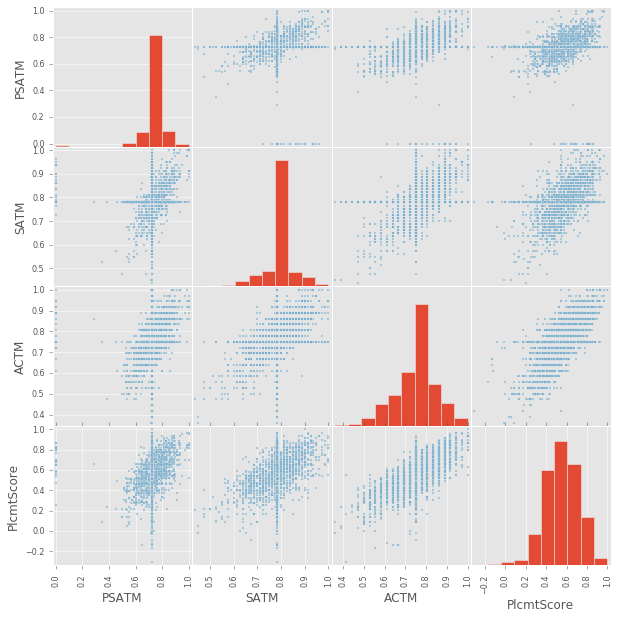

In [284]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
ff = pd.tools.plotting.scatter_matrix(dfScaled, diagonal='hist',figsize=(10,10))

##### Linear regression model 
- Placement test

In [297]:
features = dfScaled.columns.tolist()
response = ['PlcmtScore']
features.remove(response[0])
from sklearn import linear_model
#lr = linear_model.BayesianRidge()
lr = linear_model.LinearRegression(fit_intercept=True)
y = np.asarray(dfScaled[response])

X = dfScaled[features]
regr = lr.fit(X, y)
coefs = regr.coef_[0]

In [298]:
dataRegQ = []
dataRegQ.append(('Intercept', regr.intercept_[0]))
for i in range(len(features)):
    dataRegQ.append((features[i], coefs[i]))
yh = regr.predict(X)
yh

array([[ 0.44863246],
       [ 0.43050683],
       [ 0.54675161],
       ..., 
       [ 0.65994719],
       [ 0.68554813],
       [ 0.76788959]])

In [290]:
from sklearn.metrics import r2_score
print 'R-Squared: ', r2_score(y, yh)
pd.DataFrame(dataRegQ, columns=['feature_name', 'coefficient'])

R-Squared:  0.567018878869


,feature_name,coefficient
0,Intercept,-0.683366
1,PSATM,0.058883
2,SATM,0.493926
3,ACTM,1.072847


##### Visualize the model accuracy

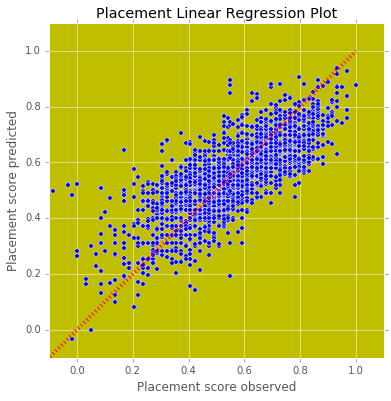

In [299]:
fig, ax=plt.subplots()
ax.scatter(y, yh)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r:', lw=4)
ax.set_xlabel('Placement score observed')
ax.set_ylabel('Placement score predicted')
ax.axis([-0.1, 1.1, -0.1, 1.1])
ax.set_axis_bgcolor('y')
ax.set_title('Placement Linear Regression Plot')
plt.gcf().set_size_inches((6,6))
plt.show()


##### Identify student need more training based on Place test score